### More In-Depth Visualization of Data

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.mplot3d import Axes3D
import astropy.units as u
from astropy.coordinates import SkyCoord, Galactic

script_path = os.getcwd()
root = os.path.abspath(os.path.join(script_path, os.pardir))
input_path = os.path.join(root, 'data', 'processed', '6d_cartesian_data.csv')

In [3]:
# import cartesian dataframe
df = pd.read_csv(input_path)
pd.set_option('display.width', 180)

print(df)

    HVS            source_id          x     x_err          y      y_err          z      z_err            u       u_err           v       v_err           w       w_err
0     1   577294697514301440 -67.141933  8.438718 -64.186365   9.177415  53.311139   7.619493  -560.470960  218.150459 -449.442002  150.701069  129.426068  236.344030
1     4   699811079173836928 -53.434490  6.910195 -11.966049   1.824832  43.273238   6.596031  -430.409845   55.487634  -45.279057   63.327725  348.840260   58.872028
2     5  1069326945513133952 -36.742892  3.302235  19.187305   2.213800  27.743604   3.198612  -401.842201   15.578334  295.450369   30.065175  415.325001   16.334296
3     6  3867267443277880320 -20.676900  1.567572 -25.006892   3.122289  47.758008   5.960332  -112.439516   73.728939    6.388857   56.875941  555.888328   37.289246
4     7  3799146650623432704 -10.982208  0.342121 -27.517795   3.291487  44.228082   5.287767   -37.791226   42.473680  -37.215798   30.018263  450.014809   19.64937

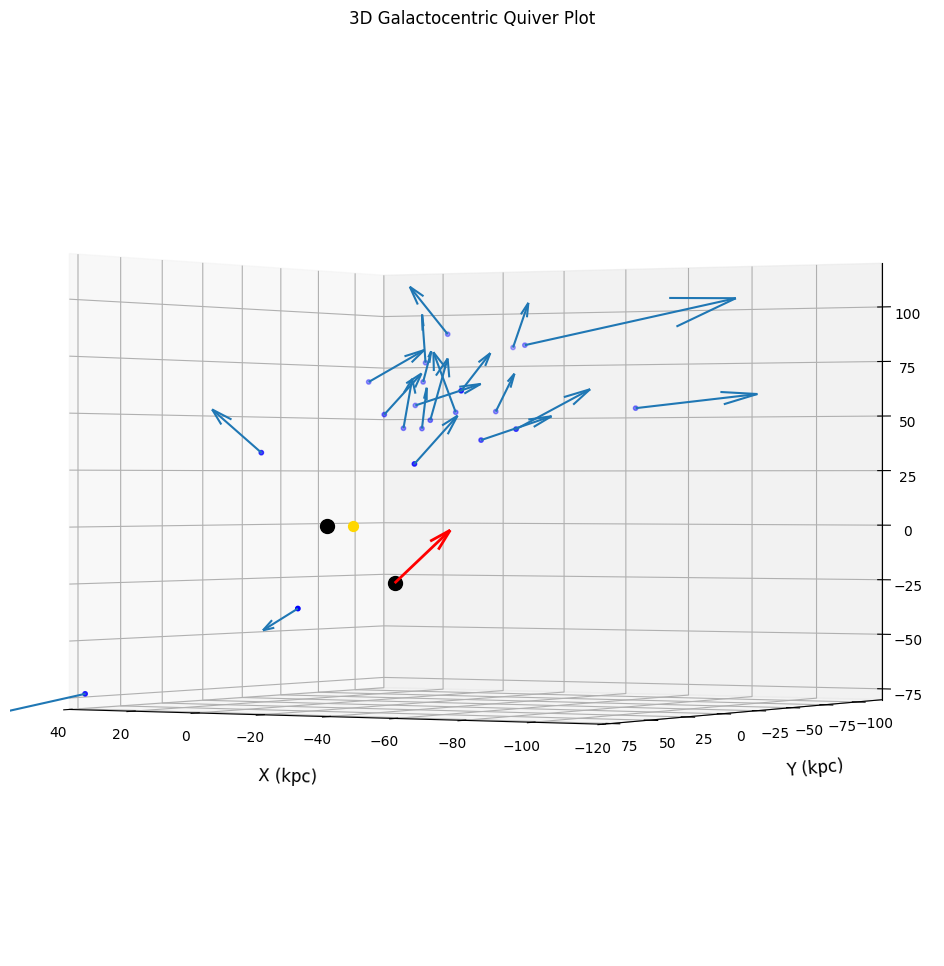

In [4]:
# 3d galactocentric quiver plot
fig = plt.figure(figsize=(14,12))
ax = fig.add_subplot(111, projection='3d')

quiver = ax.quiver(
    df['x'], df['y'], df['z'],
    df['u'], df['v'], df['w'],
    length = 0.05,
    label="HVS and Velocity Vectors"
)
# HVS positions
ax.scatter(df['x'], df['y'], df['z'], color='blue', s=10, label='HVS Positions')
# Galactic Center
ax.scatter(0,0,0, color='black', s=100, label='Saggitarius A*')
# Sun
ax.scatter(-8.2, 0, 0.02, color='gold', s=50, label='Sun')
# LMC*
lmc_pos = [-1.5, -41.4, -26.7]
ax.scatter(lmc_pos[0], lmc_pos[1], lmc_pos[2], color='black', s=100, label='LMC*')
lmc_vel = [-57, -226, 221] # U, V, W in km/s
ax.quiver(
    lmc_pos[0], lmc_pos[1], lmc_pos[2], # Start the arrow at the LMC's position
    lmc_vel[0], lmc_vel[1], lmc_vel[2], # Vector components
    length=35.0, # Make the vector long enough to be easily visible
    normalize=True,
    color='red',
    linewidth=2,
    arrow_length_ratio=0.3,
    label='LMC Velocity Vector'
)

ax.set_xlabel('X (kpc)', fontsize=12, labelpad=20)
ax.set_ylabel('Y (kpc)', fontsize=12, labelpad=20)
ax.set_zlabel('Z (kpc)', fontsize=12, labelpad=20)
ax.set_xlim([-120, 40])
ax.set_ylim([-120, 80])
ax.set_zlim([-80, 120])

ax.set_title('3D Galactocentric Quiver Plot')
ax.view_init(elev=0., azim=120)
plt.show()

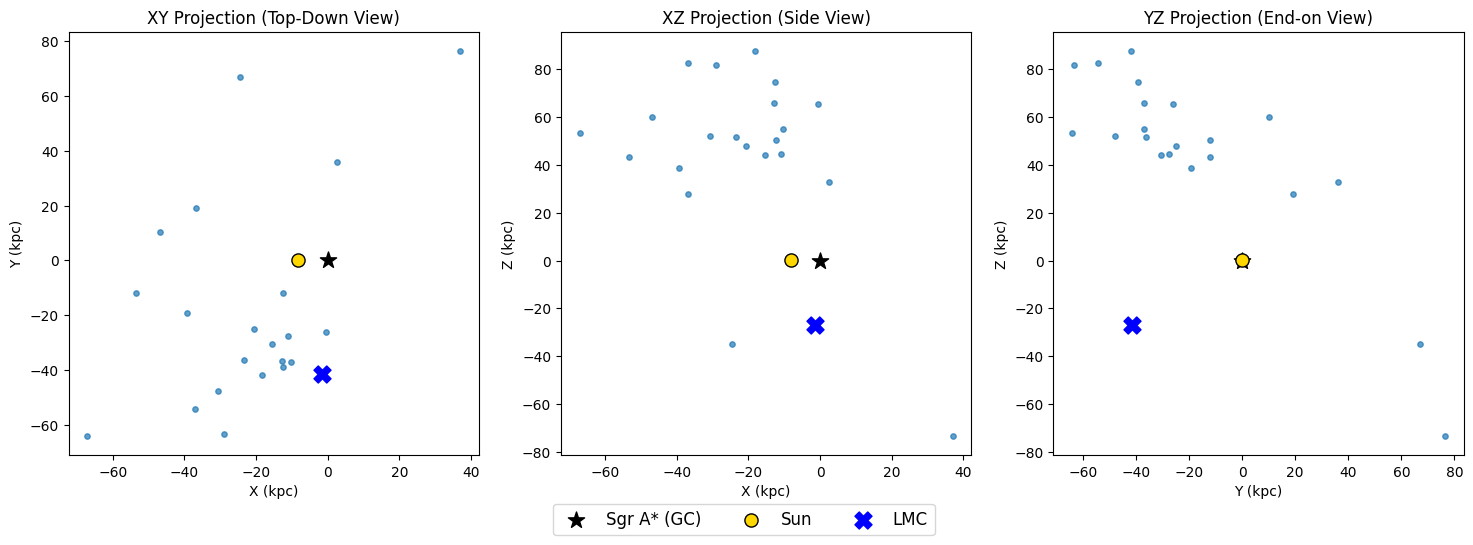

In [5]:
# xz, yz, xy plots of HVS in galactocentric frame
x = df['x']
y = df['y']
z = df['z']
sun_pos = {'x': -8.2, 'y': 0, 'z': 0.02}
lmc_pos = {'x': -1.5, 'y': -41.4, 'z': -26.7}

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(18, 5.5))

ax1.scatter(x, y, s=15, alpha=0.7)
ax1.set_title('XY Projection (Top-Down View)')
ax1.set_xlabel('X (kpc)')
ax1.set_ylabel('Y (kpc)')
ax1.scatter(0, 0, color='black', s=150, marker='*', label='Sgr A* (GC)')
ax1.scatter(sun_pos['x'], sun_pos['y'], color='gold', s=90, label='Sun', edgecolors='black')
ax1.scatter(lmc_pos['x'], lmc_pos['y'], color='blue', s=150, marker='X', label='LMC')

ax2.scatter(x, z, s=15, alpha=0.7)
ax2.set_title('XZ Projection (Side View)')
ax2.set_xlabel('X (kpc)')
ax2.set_ylabel('Z (kpc)')
ax2.scatter(0, 0, color='black', s=150, marker='*')
ax2.scatter(sun_pos['x'], sun_pos['z'], color='gold', s=90, edgecolors='black')
ax2.scatter(lmc_pos['x'], lmc_pos['z'], color='blue', s=150, marker='X')

ax3.scatter(y, z, s=15, alpha=0.7)
ax3.set_title('YZ Projection (End-on View)')
ax3.set_xlabel('Y (kpc)')
ax3.set_ylabel('Z (kpc)')
ax3.scatter(0, 0, color='black', s=150, marker='*')
ax3.scatter(sun_pos['y'], sun_pos['z'], color='gold', s=90, edgecolors='black')
ax3.scatter(lmc_pos['y'], lmc_pos['z'], color='blue', s=150, marker='X')

handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.05), fontsize=12, fancybox=True)
plt.show()

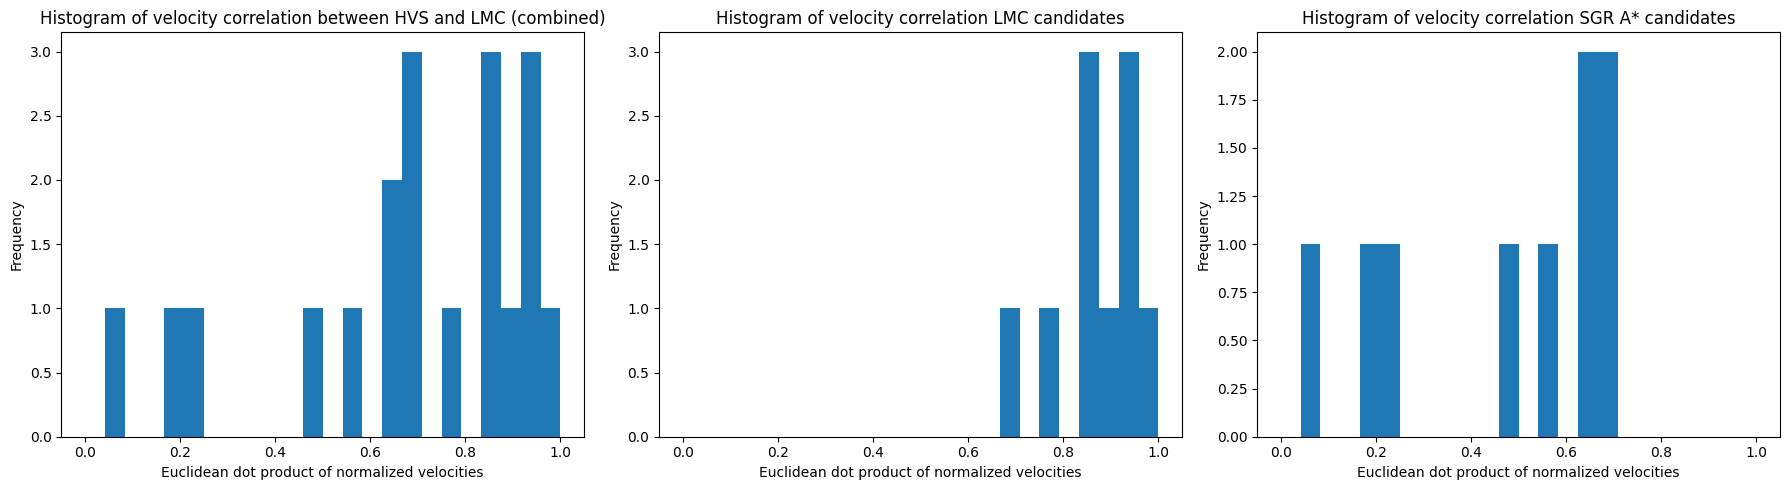

Higher correlation with LMC* vel: [6, 7, 9, 10, 13, 15, 16, 20, 22, 24]
Lower correlation with LMC* vel: [1, 4, 5, 8, 12, 14, 17, 18, 19, 21, 23]
12 incorrectly identified
13 incorrectly identified
Predictive accuracy: 0.875 using a threshold of 0.7


In [ ]:
# HVS velocity correlation with LMC velocity histogram
import seaborn as sb

# define galactocentric velocity of LMC from this paper https://arxiv.org/pdf/1301.0832 (Table 5)
lmc_v_x = -57
lmc_v_y = -226
lmc_v_z = 221
lmc_v_tot = 321

lmc_vel = np.array([lmc_v_x, lmc_v_y, lmc_v_z])
lmc_vel_unit = lmc_vel / np.linalg.norm(lmc_vel)

dots = []
bins = np.linspace(0,1,25)
threshold = 0.7
suspect_lmc = []
suspect_sgr = []

for index, data in df.iterrows():
    v_x = data['u']
    v_y = data['v']
    v_z = data['w']

    curr_v = np.array([v_x, v_y, v_z])
    curr_v_unit = curr_v / np.linalg.norm(curr_v)
    corr = np.dot(lmc_vel_unit, curr_v_unit)
    dots.append(corr)

    # higher correlation between HVS velocity and LMC velocity, suspect LMC origin
    if corr > threshold:
        suspect_lmc.append(int(data['HVS']))
    else:
        suspect_sgr.append(int(data['HVS']))

# lmc alignment into dataframe
df['lmc_alignment'] = dots
# for separate LMC, GC plots
lmc_mask = df['lmc_alignment'] > threshold
sgr_mask = df['lmc_alignment'] <= threshold
lmc_candidates = df[lmc_mask]
sgr_candidates = df[sgr_mask]

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(18,5))

ax1.hist(dots, bins=bins)
ax1.set_title('Histogram of velocity correlation between HVS and LMC (combined)')
ax1.set_xlabel('Euclidean dot product of normalized velocities')
ax1.set_ylabel('Frequency')

ax2.hist(lmc_candidates['lmc_alignment'].values, bins=bins)
ax2.set_title('Histogram of velocity correlation LMC candidates')
ax2.set_xlabel('Euclidean dot product of normalized velocities')
ax2.set_ylabel('Frequency')

ax3.hist(sgr_candidates['lmc_alignment'].values, bins=bins)
ax3.set_title('Histogram of velocity correlation SGR A* candidates')
ax3.set_xlabel('Euclidean dot product of normalized velocities')
ax3.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

print("Higher correlation with LMC* vel: " + str(suspect_lmc))
print("Lower correlation with LMC* vel: " + str(suspect_sgr))

# compare with actual predictions from Han. 0 represents higher likelihood assigned to SGR A* origin, 1 is higher likelihood assigned to LMC*
# paper: https://arxiv.org/pdf/2502.00102
truth_hvs = [1, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
truth = [0, 0, None, 1, 1, None, 1, 1, 1, 0, None, 1, 1, None, 0, 0, 1, 0, 1, None, 1]

correct_ctr = 0
for i in range(len(truth_hvs)):
    hvs = truth_hvs[i]
    truth_val = truth[i]
    if truth_val != None:
        if truth_val == 1 and hvs in suspect_lmc:
            correct_ctr+=1
        elif truth_val == 0 and hvs in suspect_sgr:
            correct_ctr+=1
        else:
            print(str(hvs) + " incorrectly identified")

print("Predictive accuracy: " + str(correct_ctr/16) + " using a threshold of " + str(threshold)) # 16 comes from 21 HVS - 5 inconclusive ones (no LMC or SGR A* prediction)


In [7]:
# point biserial correlation coefficient for asserting signficance of velocity correlation to truth
from scipy import stats

truth_data = {
    'HVS': truth_hvs,
    'truth': truth
}
truth_df = pd.DataFrame(truth_data)

if 'truth' not in df.columns:
    df['HVS'] = df['HVS'].astype(int)
    df = pd.merge(df, truth_df, on='HVS')
    df.dropna(subset=['truth'], inplace=True) #drop no predictions
    df['truth'] = df['truth'].astype(int)

# point biserial coefficient, used for one continous and one binary var
correlation, p_value = stats.pointbiserialr(df['lmc_alignment'], df['truth'])
print(f"\nPoint-Biserial Correlation Coefficient: {correlation:.4f}")
print(f"P-value: {p_value:.4f}")


Point-Biserial Correlation Coefficient: 0.4718
P-value: 0.0650


In [37]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# define function for 3d ellipse visualization
def plot_ellipsoid(ax, center, cov_matrix, n_sigma=1, n_points=100, **kwargs):
    """
    Plots 3D ellipsoid representing correlated uncertainty for position vectors of the HVS.

    Parameters:
        - ax: The matplotlib subplot to plot on
        - center: Center of ellipsoid
        - cov_matrix: 3x3 positional covariance matrix (xx, xy, xz, yy, yz, zz)
        - n_sigma: The number of std. deviations to visualize ellipsoid
        - n_points: Number of points for drawing surface via mesh. More points -> higher resolution
    """

    cov_matrix = np.asarray(cov_matrix) # convert to numpy array for later functions
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    eigenvalues[eigenvalues < 0] = 0
    
    # calculate the radii of the ellipsoid from eigenvalues, scaled by n_sigma
    e_radii = np.sqrt(eigenvalues) * n_sigma
    print("Ellipse radii: " + str(e_radii))

    # generate n_points on unit sphere by parameterization and transform to ellipse
    u = np.linspace(0, 2 * np.pi, n_points)
    v = np.linspace(0, np.pi, n_points)
    
    x_ell = np.zeros((n_points, n_points)) # preallocate space
    y_ell = np.zeros((n_points, n_points))
    z_ell = np.zeros((n_points, n_points))

    # find way to vectorize for faster
    for i, u_val in enumerate(u):
        for j, v_val in enumerate(v):
            unit_sphere_pt = np.array([
                np.cos(u_val) * np.sin(v_val), # standard 2d parameterization of unit sphere
                np.sin(u_val) * np.sin(v_val),
                np.cos(v_val)
            ])
             
            # scale by eigenvalues 
            scaled_pt = np.diag(e_radii) @ unit_sphere_pt
            # multiply by eigenvector matrix to tilt to proper orientation
            rotated_pt = eigenvectors @ scaled_pt
            final_pt = rotated_pt + center # center at mean values
            
            x_ell[i, j], y_ell[i, j], z_ell[i, j] = final_pt

    ax.plot_wireframe(x_ell, y_ell, z_ell, **kwargs)
    return x_ell, y_ell, z_ell

print("Function defined.")

Function defined.


Data loaded. Generating plots...
Ellipse radii: [0.00000000e+00 3.01125340e-07 1.46115657e+01]
Ellipse radii: [0.0000000e+00 9.0337602e-07 4.3834697e+01]
Ellipse radii: [0.00000000e+00 1.78813934e-07 9.72575613e+00]
Ellipse radii: [0.00000000e+00 5.36441803e-07 2.91772684e+01]
Ellipse radii: [1.31935531e-08 8.32547747e-08 5.10267599e+00]
Ellipse radii: [3.95806592e-08 2.49764324e-07 1.53080280e+01]
Ellipse radii: [0.00000000e+00 1.19257187e-07 6.90887016e+00]
Ellipse radii: [0.00000000e+00 3.57771561e-07 2.07266105e+01]
Ellipse radii: [0.00000000e+00 8.43115159e-08 6.23796314e+00]
Ellipse radii: [0.00000000e+00 2.52934548e-07 1.87138894e+01]
Ellipse radii: [0.00000000e+00 1.20344861e-07 9.77556821e+00]
Ellipse radii: [0.00000000e+00 3.61034582e-07 2.93267046e+01]
Ellipse radii: [0.00000000e+00 1.59097646e-07 1.16213051e+01]
Ellipse radii: [0.00000000e+00 4.77292939e-07 3.48639152e+01]
Ellipse radii: [0.00000000e+00 6.77795167e-08 5.71985279e+00]
Ellipse radii: [0.00000000e+00 2.0333855

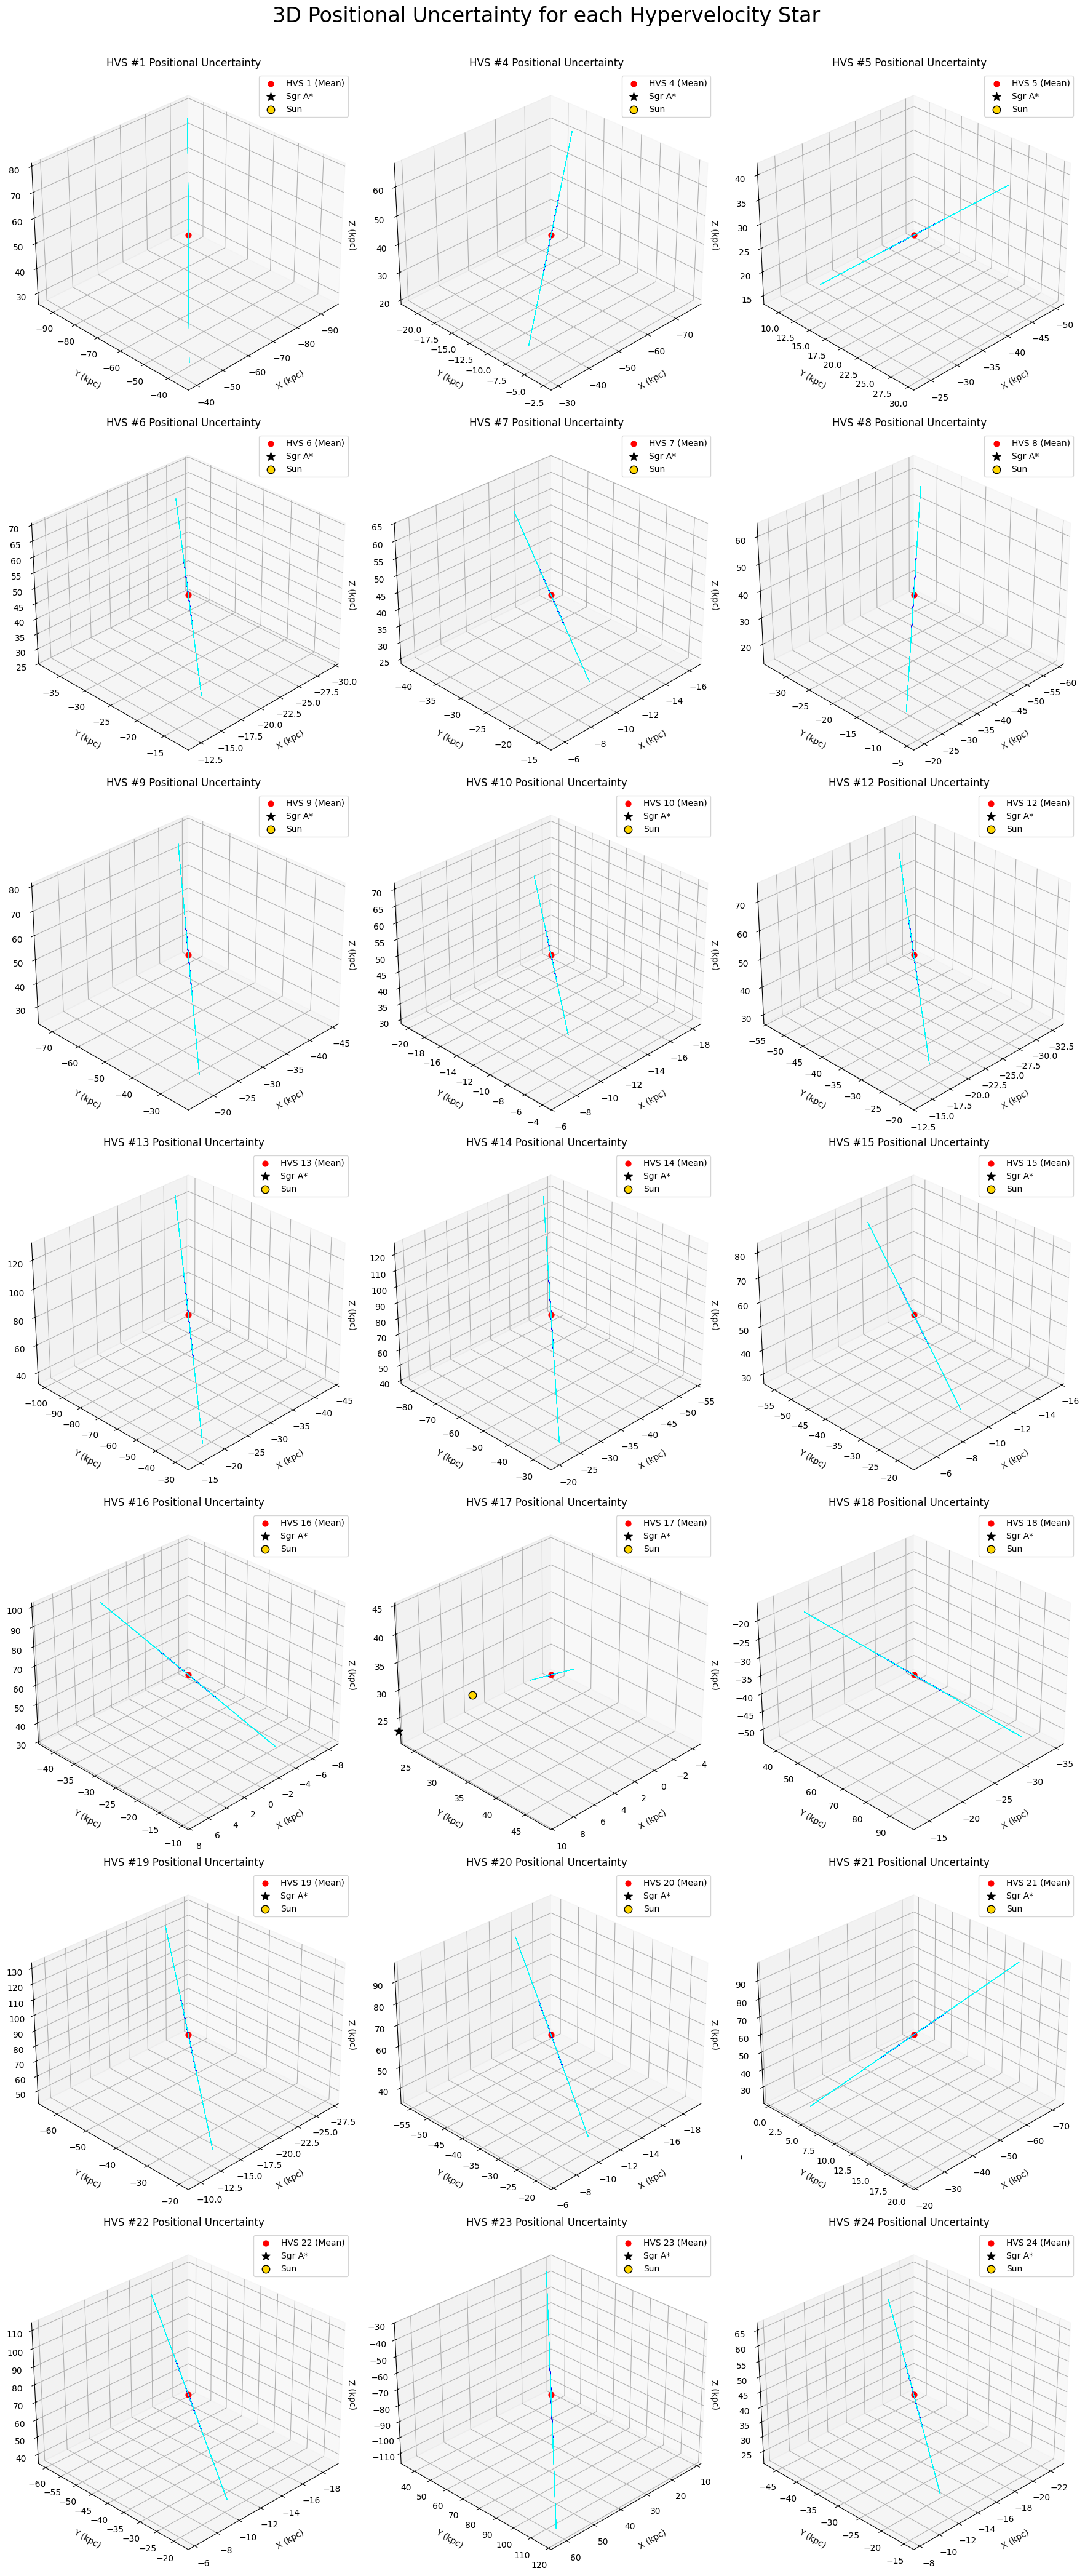

In [38]:
# processing loop for 3d ellipsoid visualization
script_dir = os.getcwd()
root = os.path.join(script_dir, os.pardir)
cartesian_path = os.path.join(root, 'data', 'processed', '6d_cartesian_data.csv')
covariance_path = os.path.join(root, 'data', 'processed', '6d_cartesian_covariance.csv')

try:
    df_cartesian = pd.read_csv(cartesian_path)
    df_covariance = pd.read_csv(covariance_path)
except FileNotFoundError:
    print("Error: Could not find script.")

# merge dataframes and ensure clean/proper format
df = pd.merge(df_cartesian, df_covariance, on=['HVS', 'source_id'])
df = df.sort_values('HVS').reset_index(drop=True) #make sure HVS in order 1..24 and properly indexed

print("Data loaded. Generating plots...")

fig, axes = plt.subplots(7, 3, figsize=(18, 42), subplot_kw={'projection': '3d'})
axes = axes.flatten()

sun_pos = np.array([-8.2, 0, 0.02])
gc_pos = np.array([0, 0, 0])

for i, (index, star) in enumerate(df.iterrows()):
    ax = axes[i]
    hvs_id = int(star['HVS'])

    center_pos = np.array([star['x'], star['y'], star['z']])
    cov_pos = np.array([
        [star['cov_xx'], star['cov_xy'], star['cov_xz']],
        [star['cov_xy'], star['cov_yy'], star['cov_yz']],
        [star['cov_xz'], star['cov_yz'], star['cov_zz']]
    ])

    ax.scatter(center_pos[0], center_pos[1], center_pos[2], color='red', s=40, label=f'HVS {hvs_id} (Mean)')
    ax.scatter(gc_pos[0], gc_pos[1], gc_pos[2], color='black', s=100, marker='*', label='Sgr A*')
    ax.scatter(sun_pos[0], sun_pos[1], sun_pos[2], color='gold', s=80, label='Sun', edgecolors='black')

    plot_ellipsoid(ax, center_pos, cov_pos, n_sigma=1, color='blue', alpha=0.5, linewidth=0.75)

    x_3s, y_3s, z_3s = plot_ellipsoid(ax, center_pos, cov_pos, n_sigma=3, color='cyan', alpha=0.4, linewidth=0.5)
    padding = 5
    ax.set_xlim(np.min(x_3s) - padding, np.max(x_3s) + padding)
    ax.set_ylim(np.min(y_3s) - padding, np.max(y_3s) + padding)
    ax.set_zlim(np.min(z_3s) - padding, np.max(z_3s) + padding)

    ax.set_title(f'HVS #{hvs_id} Positional Uncertainty', fontsize=12)
    ax.set_xlabel('X (kpc)', labelpad=10)
    ax.set_ylabel('Y (kpc)', labelpad=10)
    ax.set_zlabel('Z (kpc)', labelpad=10)
    ax.legend()
    ax.view_init(elev=30, azim=45)

for i in range(len(df), len(axes)):
    axes[i].set_visible(False)

fig.suptitle('3D Positional Uncertainty for each Hypervelocity Star', fontsize=24, y=0.995)
plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.show()
